## 0: 导入必要软件包

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import os

## 1. 定义模型

- $𝑑𝑆/𝑑𝑡=−𝛽𝑆𝐼$
- $𝑑𝐸/𝑑𝑡=  𝛽𝑆𝐼 −\epsilon𝐸$
- $𝑑𝐼/𝑑𝑡=   \epsilon𝐸−𝛾𝐼$
- $𝑑𝑅/𝑑𝑡=             𝛾𝐼$


In [3]:
import scipy.integrate as spi
from scipy.optimize import minimize

def SEIR_base_eqs(INPUT, t, beta, epsilon, gamma):
    # INPUT表示上一天结果
    Y = np.zeros((4))
    beta = max(beta, 0)
    epsilon = max(epsilon, 0)
    gamma = max(gamma, 0)
    
    # 第t天的方程
    Y[0] = - (beta * INPUT[0] * INPUT[2]) # S 的变化量
    Y[1] = (beta * INPUT[0] * INPUT[2]) - (epsilon * INPUT[1]) # E的变化量
    Y[2] = (epsilon * INPUT[1]) - (gamma * INPUT[2]) # I的变化量
    Y[3] = (gamma * INPUT[2]) # R的变化量

    return Y

## 2. 指定参数，初始值

In [54]:
# beta(感染率), epsilon(发病率), gamma(退出率)
params = (2.8e-6, 1/7, 1/15)
S0 = 600000
E0 = 0
I0 = 1
R0 = 0

t = 200
t_range = np.arange(0, t, 1)

## 3. 开始仿真

In [55]:
RES = spi.odeint(SEIR_base_eqs, (S0, E0, I0, R0), t_range, args = params)

In [56]:
RES.shape

(200, 4)

一个360天$\times$4列的数组，分别表示每天的$S, E, I, R$

将结果作图如下

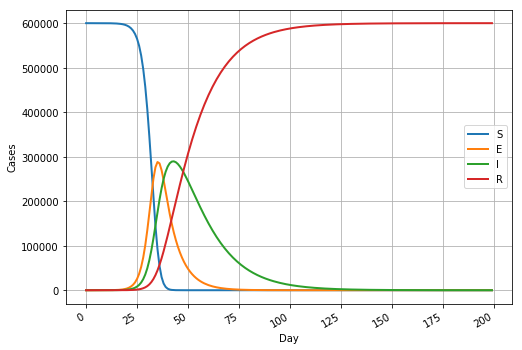

In [61]:
plt.figure(figsize = (8, 6))
plt.plot(t_range, RES[:, 0],  label = 'S', linewidth=2)
plt.plot(t_range, RES[:, 1],  label = 'E', linewidth=2)
plt.plot(t_range, RES[:, 2],  label = 'I', linewidth=2)
plt.plot(t_range, RES[:, 3],  label = 'R', linewidth=2)
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.xlabel('Day')
plt.ylabel('Cases')
#     plt.savefig(path+'{}-document_{}days.jpg'.format(cityname, disp_days))
plt.show()

# 将模型使用真实数据校准

## 4. 数据读取与处理 


In [70]:
origin_data = pd.read_csv('./data/epi_confirm_new0723.csv')

In [71]:
origin_data.head()

,ID,city,population,2020/4/5,2020/4/6,2020/4/7,2020/4/8,2020/4/9,2020/4/10,2020/4/11,...,2020/7/13,2020/7/14,2020/7/15,2020/7/16,2020/7/17,2020/7/18,2020/7/19,2020/7/20,2020/7/21,2020/7/22
0,0,意大利,6043,128948,132547,135586,139422,143626,147577,152271,...,243230,243344,243506,243736,243967,244216,244434,244624,244752,245032


In [72]:
epidemic = origin_data.drop(['population', ], axis= 1)
epidemic = np.array(epidemic)

In [73]:
city_ID = {}
ID_city = {}
for _, row in origin_data.iterrows():
    city_ID[row['city']] = int(row['ID'])
    ID_city[int(row['ID'])] = row['city']

In [74]:
population = origin_data[['ID', 'city', 'population']]

In [75]:
cure_origin = pd.read_csv('./data/epi_cure_new0723.csv')
cure_origin = cure_origin.fillna(0)
cure = np.array(cure_origin.drop(['population', ], axis= 1))
cure_origin.head()

,ID,city,population,2020/4/5,2020/4/6,2020/4/7,2020/4/8,2020/4/9,2020/4/10,2020/4/11,...,2020/7/13,2020/7/14,2020/7/15,2020/7/16,2020/7/17,2020/7/18,2020/7/19,2020/7/20,2020/7/21,2020/7/22
0,0,意大利,6043,21815,22837,24392,26491,28470,30455,32534,...,195106,195441,196016,196246,196483,196806,196949,197162,197431,197628


In [76]:
death_origin = pd.read_csv('./data/epi_death_new0723.csv')
death_origin = death_origin.fillna(0)
death = np.array(death_origin.drop(['population', ], axis= 1))
death_origin.head()

,ID,city,population,2020/4/5,2020/4/6,2020/4/7,2020/4/8,2020/4/9,2020/4/10,2020/4/11,...,2020/7/13,2020/7/14,2020/7/15,2020/7/16,2020/7/17,2020/7/18,2020/7/19,2020/7/20,2020/7/21,2020/7/22
0,0,意大利,6043,15887,16523,17127,17669,18279,18849,19468,...,34967,34984,34997,35017,35028,35042,35045,35058,35073,35082


In [77]:
alldates = list(origin_data.columns)[3:]
# alldates

In [78]:
population = np.array(population)

In [79]:
def get_ci(predict_value):
    s = np.random.poisson(predict_value, 1000000)
    return np.percentile(s, [2.5, 97.5])

## 5. 定义距离函数
记$I(t), R(t)$为真实值，$\hat{I}(t), \hat{R}(t)$为模型预测值，则有

$$预测误差=\sum_{t=1}^N ((I(t)-\hat{I}(t))^2 + (R(t)-\hat{R}(t))^2)$$

In [80]:
import scipy.integrate as spi
import numpy as np
from sklearn.model_selection import ParameterGrid

from scipy.optimize import minimize

def SEIR_loss(TRUE, PRED):
    return np.sum(np.square((TRUE[:, 0] - TRUE[:, 1]) - PRED[:, 2])) + np.sum(np.square(TRUE[:, 1] - PRED[:, 3]))

def optim_fun_SEIR(args):
    INPUT, t_range, TRUE = args

    v = lambda x: SEIR_loss(TRUE,
                              spi.odeint(SEIR_base_eqs, (INPUT[0], INPUT[1], INPUT[2], INPUT[3]), t_range, args = (x[0], x[1], x[2])))

    return v

## 6. 定义模型校准及仿真函数

In [81]:
def predict_Ndays_SEIR(init_S, init_E, infect_data, remove_data, N, x0_init = None):
    S0 = init_S
    E0 = init_E
    I0 = infect_data[0] - remove_data[0]
    R0 = remove_data[0]
    S0 = S0 - E0 - I0 - R0
    
    INPUT = (S0, E0, I0, R0)
    
    
    TRUE = np.array([infect_data,
                     remove_data])
    TRUE = TRUE.T
    t_range = np.arange(0, len(TRUE), 1)
    x0 = np.array([1e-6, 1/5., 9e-4]) if x0_init is None else x0_init
    print('x0', x0, INPUT)
    r = optim_fun_SEIR((INPUT, t_range, TRUE))(x0)
    print(r)
    RES = minimize(optim_fun_SEIR((INPUT, t_range, TRUE)), x0, method = 'Nelder-Mead', options = {'disp': True})

    print(RES.x)

    r = optim_fun_SEIR((INPUT, t_range, TRUE))(RES.x)
    print(r)

    x = RES.x
    t_range = np.arange(0.0, N, 1.0)
    RES = spi.odeint(SEIR_base_eqs, (INPUT[0], INPUT[1], INPUT[2], INPUT[3]), t_range, args = (x[0], x[1], x[2]))

    PRED = RES[:, 2] + RES[:, 3]# I + R
    
    return PRED, {'S': RES[:, 0], 'E': RES[:, 1], 'I': RES[:, 2], 'R': RES[:, 3], 'I+R': PRED}

In [82]:
params = {}

In [83]:
today = alldates[-1]

In [84]:
def str_to_dt(datestr):
    return dt.datetime.strptime(datestr, '%Y/%m/%d').date()
def dt_to_str(datedt):
    return datedt.strftime('%Y/%m/%d')

In [85]:
alldates_dt = [dt.datetime.strptime(d, '%Y/%m/%d').date() for d in alldates]
today_dt = alldates_dt[-1]

## 7. 进行模型校准与预测

In [86]:
params['意大利'] =np.array([1e-11, 0.2, 9e-2])

意大利
Infect: [240578 240760 240961 241184 241419 241611 241819 241956 242149 242363
 242639 242827 243061 243230 243344 243506 243736 243967 244216 244434
 244624 244752 245032]
Remove: [225015 225505 225901 226300 226798 226969 227110 227714 228554 228904
 229211 229524 229882 230073 230425 231013 231263 231511 231848 231994
 232220 232504 232710]
x0 [1.e-11 2.e-01 9.e-02] (60188389, 1033, 15563, 225015)
1722018491.923102
Optimization terminated successfully.
         Current function value: 1842939.967683
         Iterations: 320
         Function evaluations: 583
[2.89388157e-10 1.31110930e-01 2.72611265e-02]
1842939.96768264
Today and future three days prediction:  [245119.54001537 245337.07134999 245553.33864274 245768.26880982]
Ground truth of today infection:  245032


C:\Users\Dell\Miniconda3\envs\py36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


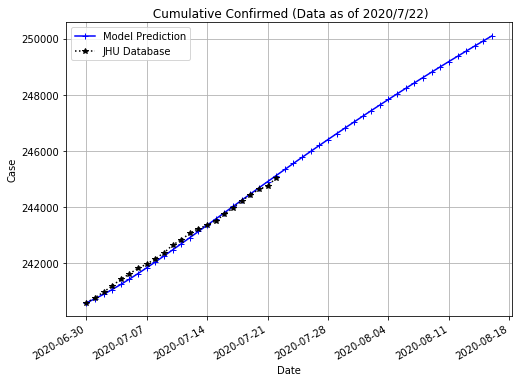

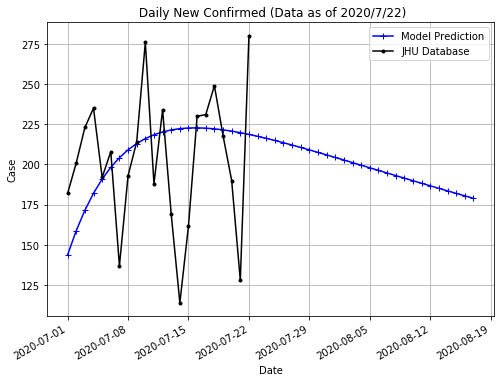

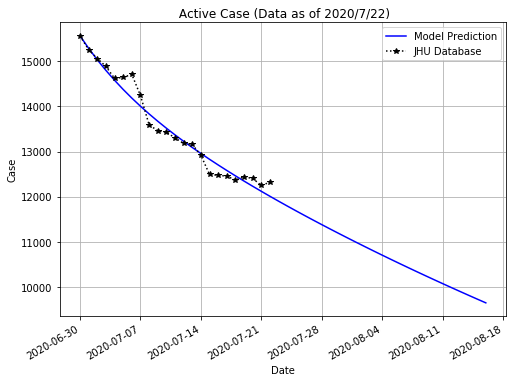

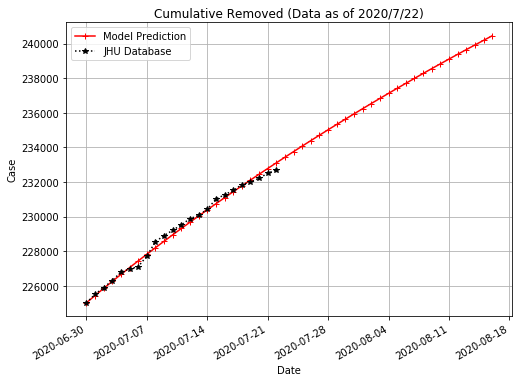

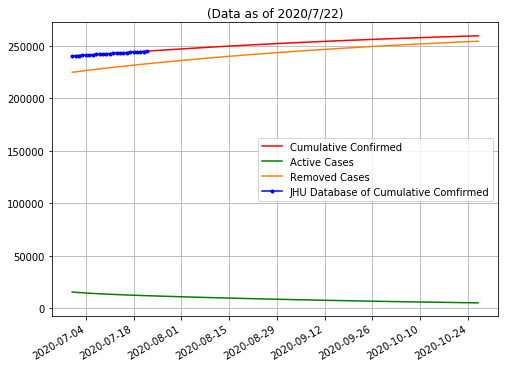

259750.58117167105



In [87]:
select_city = ['意大利']
for cityname in select_city:
    print(cityname)
    cityid = city_ID[cityname]
    startdate = '2020/6/30'
    init_S = population[cityid, 2] * 10000
    greater = np.sum(epidemic[cityid, 2:] > 0)
    window = max(14, greater)
    window = min(window, len(alldates) - alldates.index(startdate)) #wuhan 23
#     window = min(8, window)
    infect_data = epidemic[cityid, -window:]
    cure_data = cure[cityid, -window:]
    death_data = death[cityid, -window:]
    remove_data = cure_data + death_data
    print('Infect:', infect_data)
    print('Remove:', remove_data)

    try:
        x0 = params[cityname]
    except:
        x0 = None
    init_E = infect_data[5] - infect_data[0]
        
    predict_func = predict_Ndays_SEIR

    NN = 120
    PRED_ALL, data_all = predict_func(init_S, init_E, infect_data, remove_data, NN, x0_init=x0)
#     PRED_ALL[:len(infect_data) + 3] = smooth(PRED_ALL[:len(infect_data) + 3], 5)
    PRED = PRED_ALL[:len(infect_data)+3]

    print("Today and future three days prediction: ", PRED[-4: ])
    print("Ground truth of today infection: ", infect_data[-1])
    
    based_time = str_to_dt(alldates[-window])
    t_range_subdt = [based_time + dt.timedelta(days = x) for x in range(NN)]
    
    
    disp_days = 48

    path = './{}_result/'.format( str(dt.datetime.today().date()))
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'b+-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Prediction", "JHU Database"])
    plt.title(u' Cumulative Confirmed (Data as of {})'.format(alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}_accum_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 48
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[1:][:disp_days], [PRED_ALL[i+1] - PRED_ALL[i] for i in range(len(PRED_ALL)-1)][:disp_days], 'b+-')
#     plt.plot(t_range_subdt[1:][:disp_days], [ACTUAL_ALL[i+1] - ACTUAL_ALL[i] for i in range(len(ACTUAL_ALL)-1)][:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)][1:], [infect_data[i+1] - infect_data[i] for i in range(len(infect_data)-1)], 'k.-')
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Prediction", 'JHU Database'])
    plt.title(u' Daily New Confirmed (Data as of {})'.format(alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}_dailynew_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 48
    REMOVE_ALL = data_all['R']
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'b-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data - remove_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Prediction", "JHU Database"])
    plt.title(u' Active Case (Data as of {})'.format( alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}_remained_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 48
    REMOVE_ALL = data_all['R']
    
    fig3 = plt.figure(figsize=(8,6))
    ax3 = fig3.add_subplot(1,1,1)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.xticks(pd.date_range(t_range_subdt[0],t_range_subdt[disp_days],15), rotation = 40)
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'r+-')
#     plt.plot(t_range_subdt[:disp_days], ACTUAL_ALL[:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)], remove_data, "k*:")
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Prediction", 'JHU Database'])
    plt.title(u'Cumulative Removed (Data as of {})'.format( alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}-accumulated.jpg'.format(cityname))
    plt.show()
    
    disp_days = 120
    plt.figure(figsize = (8, 6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'r', label = 'Cumulative Confirmed')
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'g', label = 'Active Cases')
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'tab:orange', label = 'Removed Cases')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, 'b.-', label = 'JHU Database of Cumulative Comfirmed')
    plt.legend()
    plt.grid(True)
    plt.title(u'(Data as of {})'.format(alldates[-1]))
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}-document_{}days.jpg'.format(cityname, disp_days))
    plt.show()
    
    result = pd.DataFrame(data={
        'Date': [dt_to_str(x) for x in t_range_subdt][:len(PRED_ALL)],
        'Predict_confirm': PRED_ALL, #预测确诊数
        'Dailynew_confirm': ([0. ]+[PRED_ALL[i+1] - PRED_ALL[i] for i in range(0, len(PRED_ALL)-1)]),
        'Remove': REMOVE_ALL, #移除数
        'Dailynew_remove': ([0. ]+[REMOVE_ALL[i+1] - REMOVE_ALL[i] for i in range(0, len(REMOVE_ALL)-1)]),
        'Remain_confirm': PRED_ALL - REMOVE_ALL,
#         'Confirm_interval_down': [get_ci(x)[0] for x in PRED_ALL],
#         'Confirm_interval_up': [get_ci(x)[1] for x in PRED_ALL],
    })
    additional = pd.DataFrame(data = {
        'ADate': t_range_subdt[:len(infect_data)],
        'Official_confirmed': infect_data,
        'Official_dailynew': ([0.] + [infect_data[i+1] - infect_data[i] for i in range(0, len(infect_data)-1)]),
        'Official_cure': cure_data,
        'Official_remove': remove_data,
    })
    result = pd.concat([result, additional], axis = 1)
    
#     path = './{}_result/'.format( str(dt.datetime.today().date()))
#     if not os.path.exists(path):
#         os.makedirs(path)
#     result.to_csv(path+'{}_result_SEIR_{}.csv'.format(cityname,  alldates[-1].replace('/', '-')), index=False)
    print(np.max(PRED_ALL))
    print()